In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import requests
from bs4 import BeautifulSoup
import folium
import json
%pylab inline
%matplotlib inline
pd.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
BASE_URL = 'http://www.patentsview.org/api/patents/query?'

# `|THE USE OF API`

`The API don't give more than 10.000 patents at a time, we need to get the number of patents for every month and add them together.`

`Check 'total_patent_count' and retrieve the first page.`

In [3]:
def get_patents(year_start, month_start, year_end, month_end):
    '''Get patent_id, patent_number and patent_title for patents granted between given dates.'''
    
    query='q={"_and":[{"_gte":{"patent_date":"%d-%d-01"}},\
                      {"_lt":{"patent_date":"%d-%d-01"}}]}\
                      &o={"page":1,"per_page":100}' % (year_start, month_start, year_end, month_end)
    return requests.get(BASE_URL + query).json()

In [4]:
# GET PATENTS GRANTED ON MARCH OF 2010
patent_json = get_patents(2010, 2, 2010, 3)
patente_df = pd.DataFrame(patent_json['patents'])

In [5]:
patente_df.head()

,patent_id,patent_number,patent_title
0,7653948,7653948,Massaging clothing
1,7653949,7653949,Mitten-sleeve combination for a winter garment
2,7653950,7653950,Stiffening device for apparel
3,7653951,7653951,Flushing device comprising a pressurized chamb...
4,7653952,7653952,Bed with movable mattress


# `|GRANTED VS PENDING`

`Upon our initial examinations, we observe that there is information about patent applications and therefore, we though that we can analyze applications that are not granted yet. But as we dıg deeper we found out that ınfomatıon about patent applıcatıons are only present for granted patents and consequently, it is not possible to derive pending patent application from the dataset.`

# `| TOP COMPANIES`

In [6]:
def get_patents_company(year_start, month_start, year_end, month_end, page_num):
    '''Get assignee_organization and assignee_total_num_patents for patents granted between given dates.'''
    
    query='q={"_and":[{"_gte":{"patent_date":"%d-%d-01"}},\
                      {"_lt":{"patent_date":"%d-%d-01"}}]}\
                      &o={"page":%d,"per_page":10000}\
                      &f=["assignee_organization", "assignee_total_num_patents"]'\
                      % (year_start, month_start, year_end, month_end, page_num)
    return requests.get(BASE_URL + query).json()

In [7]:
# GET COMPANY AND TOTAL PATENT COUNT
company_total_patent = dict()
total_page_num = 10
for page_num in range(total_page_num):
    patent_json = get_patents_company(2017, 1, 2017, 5, page_num+1)
    for patent in patent_json['patents']:
        company_name = patent['assignees'][0]['assignee_organization']
        total_patent =  patent['assignees'][0]['assignee_total_num_patents']
        company_total_patent[company_name] = total_patent

In [8]:
# DATAFRAME OF COMPANY AND TOTAL PATENT COUNT
company_patent_df = pd.DataFrame(list(company_total_patent.items()))

# REMOVE NONE
company_patent_df.dropna(inplace=True)

# CHANGE COLUMN NAMES
company_patent_df.columns = ['company', 'total_patent']

# CONVERT TO INTEGER
company_patent_df.total_patent = company_patent_df.total_patent.astype('int64', copy=False)

# SORT
top_companies_df = company_patent_df.sort_values(by='total_patent', ascending=False)

In [9]:
top_companies_df.head()

,company,total_patent
10,International Business Machines Corporation,111916
115,"Samsung Electronics Co., Ltd.",72139
639,Canon Kabushiki Kaisha,65779
785,Sony Corporation,47267
455,Kabushikikaisha Toshiba,46384


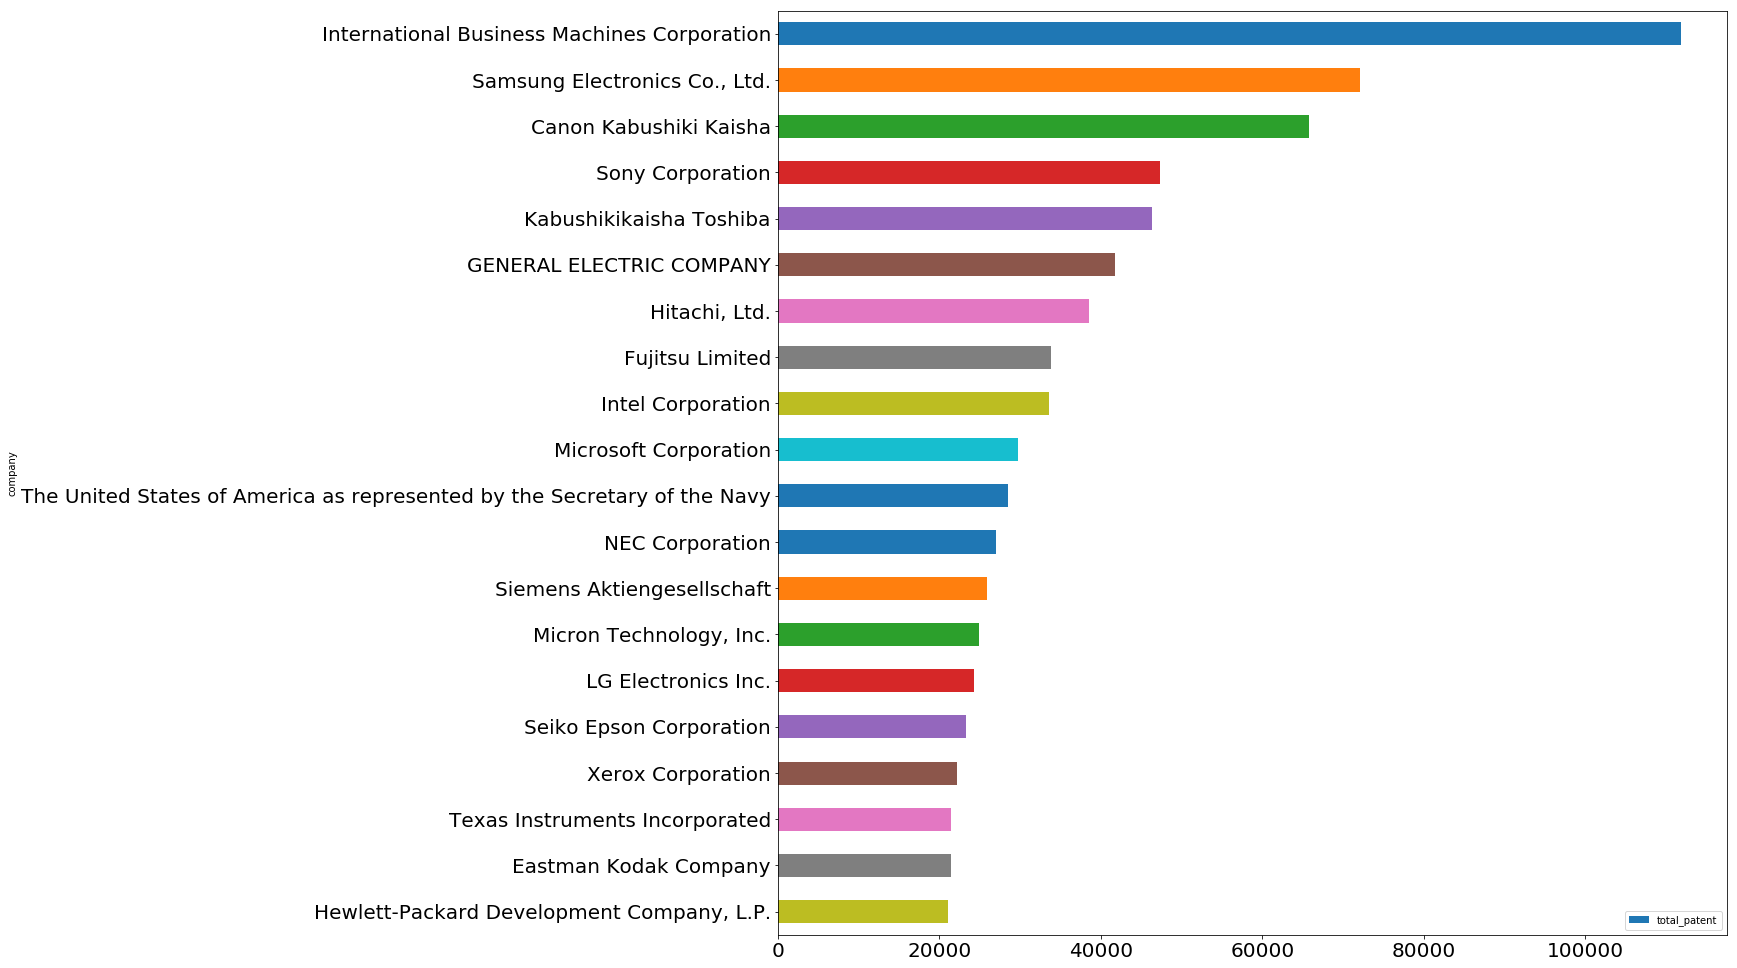

In [10]:
top_companies_df.head(20).plot.barh(x='company', y='total_patent', figsize=(17,17), fontsize=20).invert_yaxis()

# `|COUNTRY & SECTOR`

`The Cooperative Patent Classification (CPC) is a patent classification system, which has been jointly developed by the European Patent Office (EPO) and the United States Patent and Trademark Office (USPTO).`

`Patent categories according to CPC is indicated in the following table. We've used these categories for our initial analysis.` 

| `CODE` | `DESCRIPTION`   |
|------|------|
|   `A`  | `Human Necessities`|
|   `B`  | `Operations and Transport`|
|   `C`  | `Chemistry and Metallurgy`|
|   `D`  | `Textiles`|
|   `E`  | `Fixed Constructions`|
|   `F`  | `Mechanical Engineering`|
|   `G`  | `Physics`|
|   `H`  | `Electricity`|
|   `Y`  | `Emerging Cross-Sectional Technologies`|

In [11]:
def get_patents_country_sector(year_start, month_start, year_end, month_end, page_num):
    '''Get assignee_organization and assignee_total_num_patents for patents granted between given dates.'''
    
    query='q={"_and":[{"_gte":{"patent_date":"%d-%d-01"}},\
                      {"_lt":{"patent_date":"%d-%d-01"}}]}\
                      &o={"page":%d,"per_page":100}\
                      &f=["assignee_country", "cpc_group_id"]'\
                      % (year_start, month_start, year_end, month_end, page_num)
    return requests.get(BASE_URL + query).json()

In [12]:
# INITIALIZE COUNTRY
country_abbrev = list(pd.read_csv('data/countries.csv')['alpha-2'])
country_total_patent_category = dict()
for abbrev in country_abbrev:
    country_total_patent_category[abbrev] = {"A":0,"B":0,"C":0,"D":0,"E":0,"F":0,"G":0,"H":0,"Y":0,}

In [13]:
# GET COUNTRY AND TOTAL PATENT COUNT IN SECTORS
total_page_num = 30
for page_num in range(total_page_num):
    patent_json = get_patents_country_sector(2016, 1, 2017, 1, page_num+1)
    for patent in patent_json['patents']:
        country = patent['assignees'][0]['assignee_country']
        patent_categories = patent['cpcs']
        for category in patent_categories:
            if country and category['cpc_group_id'] and country != 'City of"':
                code = category['cpc_group_id'][0]
                country_total_patent_category[country][code] += 1 

In [14]:
# DATAFRAME OF COUNTRY AND TOTAL PATENT COUNT IN SECTORS
patetn_category_df = pd.DataFrame(country_total_patent_category).transpose()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1136b4f98>], dtype=object)

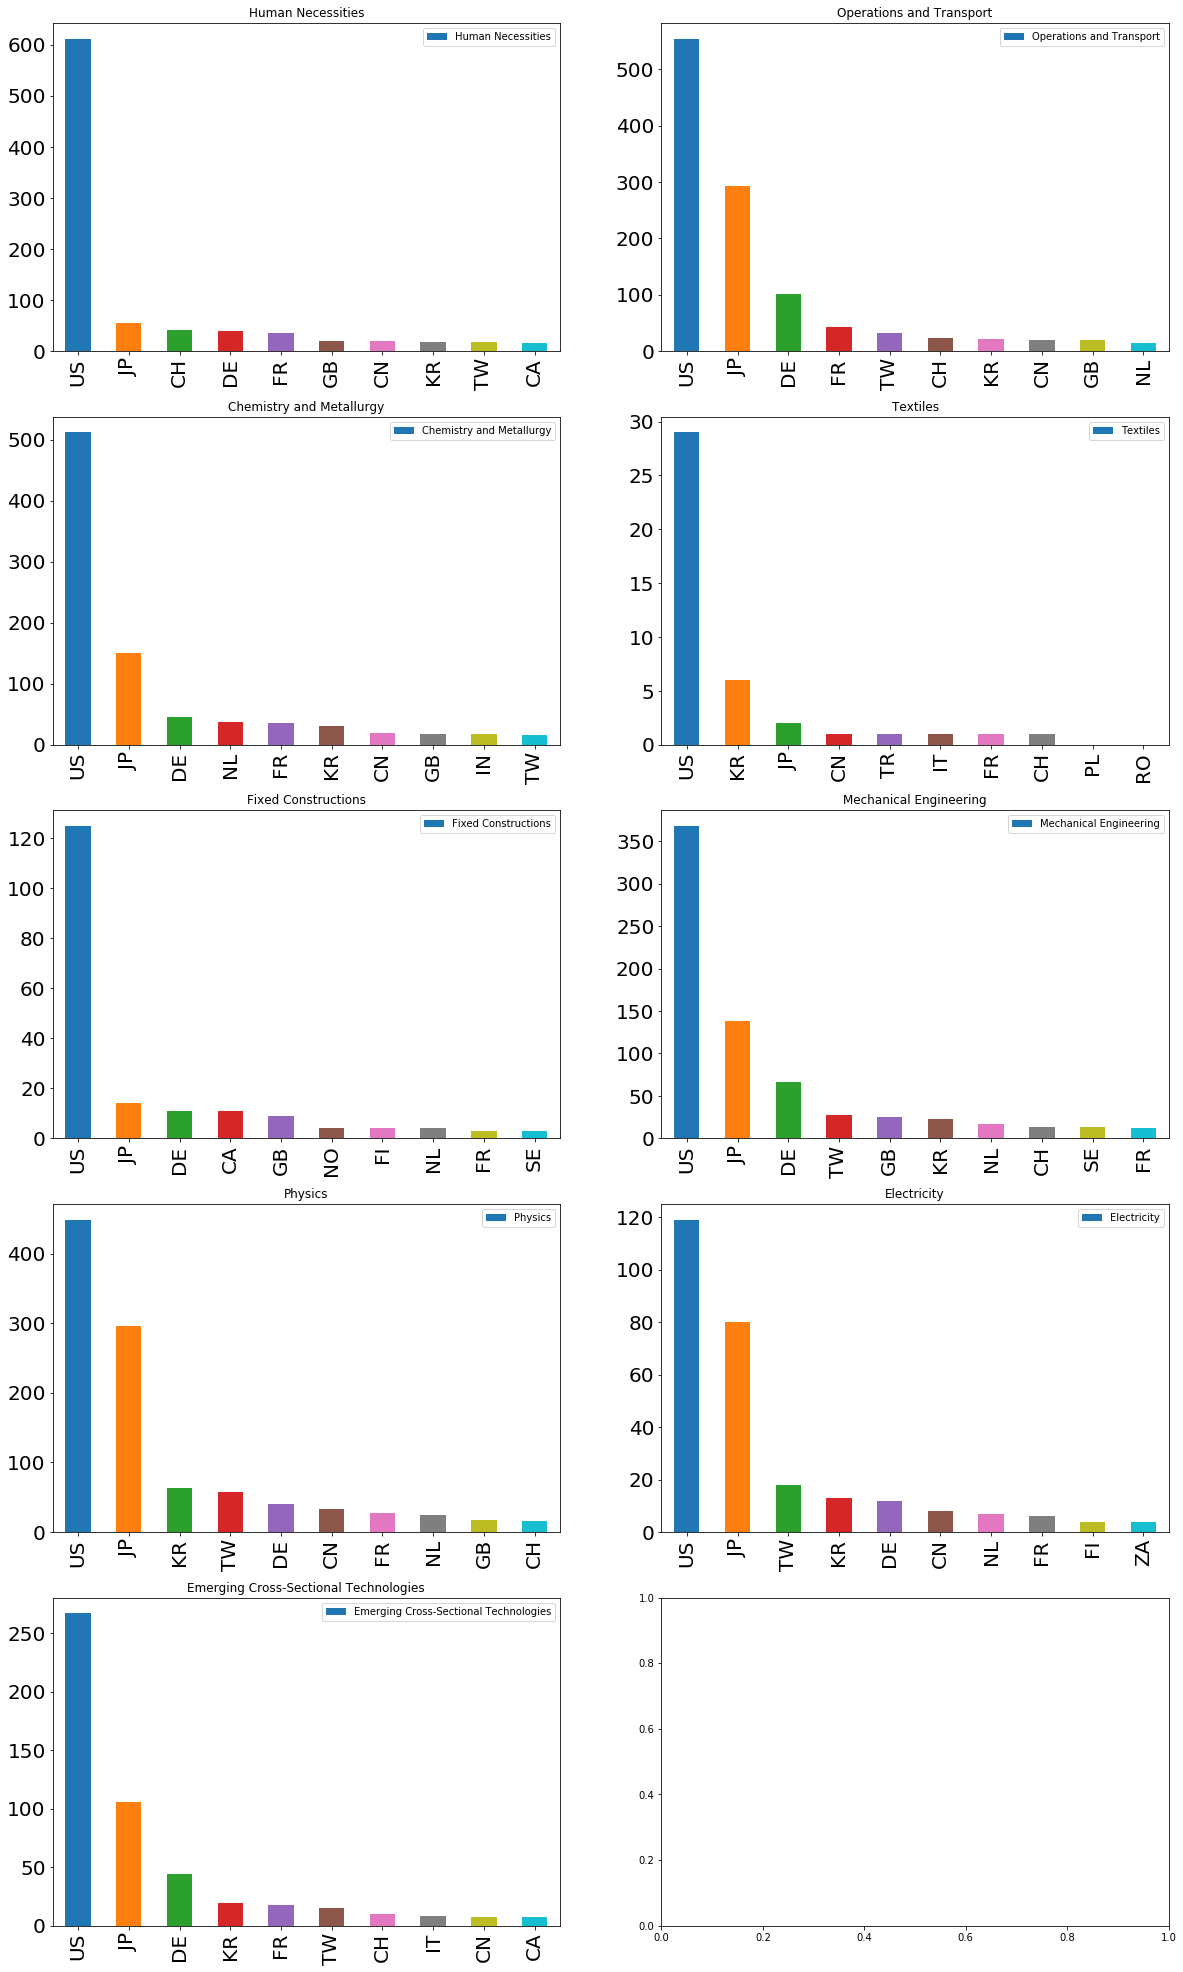

In [15]:
# PLOT TOP 10 COUNTRIES IN EACH SECTOR
fix, axes = plt.subplots(5, 2, figsize=(20, 35))
top_countries_df = patetn_category_df.sort_values(by='A', ascending=False)
top_countries_df.head(10).plot.bar(y='A', figsize=(9,7), fontsize=20, subplots=True, ax=axes[0, 0], label="Human Necessities")
top_countries_df = patetn_category_df.sort_values(by='B', ascending=False)
top_countries_df.head(10).plot.bar(y='B', figsize=(9,7), fontsize=20, subplots=True, ax=axes[0, 1], label="Operations and Transport")
top_countries_df = patetn_category_df.sort_values(by='C', ascending=False)
top_countries_df.head(10).plot.bar(y='C', figsize=(9,7), fontsize=20, subplots=True, ax=axes[1, 0], label="Chemistry and Metallurgy")
top_countries_df = patetn_category_df.sort_values(by='D', ascending=False)
top_countries_df.head(10).plot.bar(y='D', figsize=(9,7), fontsize=20, subplots=True, ax=axes[1, 1], label="Textiles")
top_countries_df = patetn_category_df.sort_values(by='E', ascending=False)
top_countries_df.head(10).plot.bar(y='E', figsize=(9,7), fontsize=20, subplots=True, ax=axes[2, 0], label="Fixed Constructions")
top_countries_df = patetn_category_df.sort_values(by='F', ascending=False)
top_countries_df.head(10).plot.bar(y='F', figsize=(9,7), fontsize=20, subplots=True, ax=axes[2, 1], label="Mechanical Engineering")
top_countries_df = patetn_category_df.sort_values(by='G', ascending=False)
top_countries_df.head(10).plot.bar(y='G', figsize=(9,7), fontsize=20, subplots=True, ax=axes[3, 0], label="Physics")
top_countries_df = patetn_category_df.sort_values(by='H', ascending=False)
top_countries_df.head(10).plot.bar(y='H', figsize=(9,7), fontsize=20, subplots=True, ax=axes[3, 1], label="Electricity")
top_countries_df = patetn_category_df.sort_values(by='Y', ascending=False)
top_countries_df.head(10).plot.bar(y='Y', figsize=(9,7), fontsize=20, subplots=True, ax=axes[4, 0], label="Emerging Cross-Sectional Technologies")

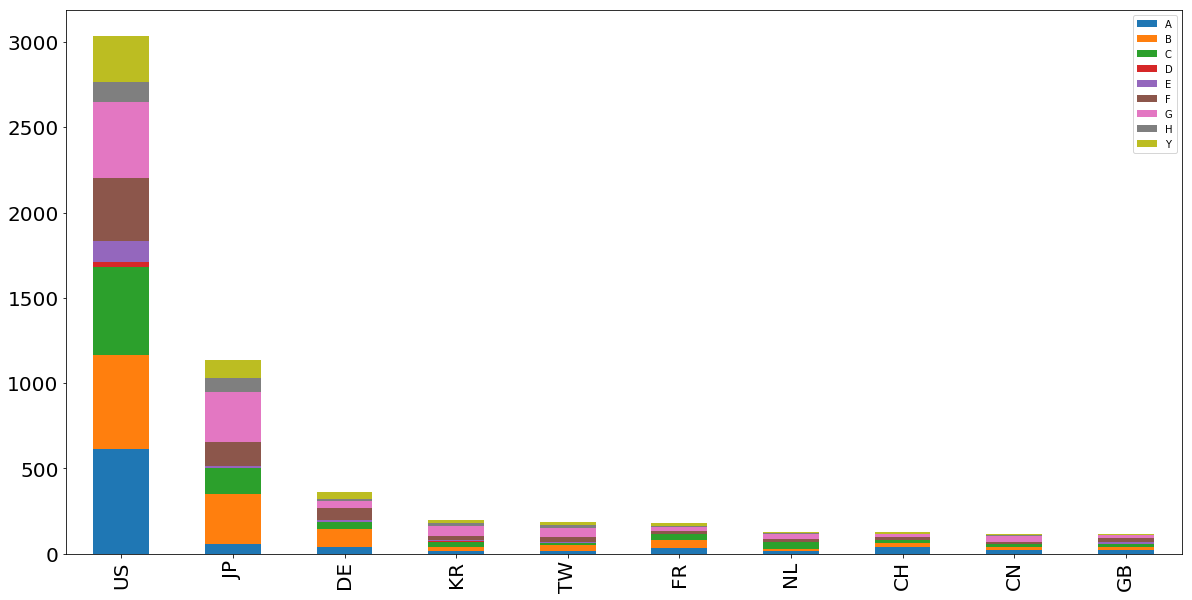

In [16]:
# PLOT TOP 10 COUNTRIES WITH STACKED BAR CHARTS
patetn_category_df['total'] = patetn_category_df.apply(sum, axis=1)
patetn_category_df.sort_values(by='total', ascending=False)\
    .drop(columns=['total']).head(10).plot.bar(stacked=True, fontsize=20, figsize=(20,10));

`As it is seen United States is the top country in all sectors. Japan also has huge number of patents. The rest of the countries are Germany (DE), South Korea (KR), Taiwan (TW), France (FR), Netherlands (NL), Switzerland (CH), China (CN), United Kingdom (GB).`